In [1]:
import torch
import pandas as pd
import numpy as np
import scipy.io
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

/home/rithvik/anaconda3/envs/csi/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-19 01:31:18.044479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 01:31:19.174944: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-19 01:31:19.175024: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugi

In [2]:
# Load the .mat file
file_path = '../EV_Rank_1_52_RBs_50_UEs_1000_snaps.mat'
data = scipy.io.loadmat(file_path)

# Extract the relevant data
EV_data = data['EV_re_im_split']

# Check the shape and structure of the extracted data
data = EV_data
del EV_data
data.shape

(50, 1000, 832)

In [3]:
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(data.shape[0]):  # iterate over samples
        for j in range(data.shape[1] - n_steps_in - n_steps_out + 1):  # iterate over timesteps
            seq_x = data[i, j:j + n_steps_in]
            seq_y = data[i, j + n_steps_in:j + n_steps_in + n_steps_out]
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)


In [4]:

n_steps_in = 10
n_steps_out = 1

X, y = create_sequences(data, n_steps_in, n_steps_out)


In [5]:
X.shape

(49500, 10, 832)

In [6]:
y.shape

(49500, 1, 832)

In [7]:
y = y.reshape((y.shape[0], y.shape[2]))


In [8]:
from sklearn.model_selection import train_test_split

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [9]:
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Testing data shape:", X_test.shape, y_test.shape)


Training data shape: (29700, 10, 832) (29700, 832)
Validation data shape: (9900, 10, 832) (9900, 832)
Testing data shape: (9900, 10, 832) (9900, 832)


In [10]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, X.shape[2])))
model.add(Dense(y.shape[1]))  # Output layer


2024-05-19 01:31:25.847971: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [11]:
model.compile(optimizer='adam', loss='mse')


In [12]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50


2024-05-19 01:31:26.475210: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 988416000 exceeds 10% of free system memory.


233/233 [==============================] - 5s 16ms/step - loss: 0.0128 - val_loss: 0.0111
Epoch 2/50
233/233 [==============================] - 3s 13ms/step - loss: 0.0105 - val_loss: 0.0102
Epoch 3/50
233/233 [==============================] - 3s 13ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 4/50
233/233 [==============================] - 3s 12ms/step - loss: 0.0097 - val_loss: 0.0097
Epoch 5/50
233/233 [==============================] - 3s 13ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 6/50
233/233 [==============================] - 3s 13ms/step - loss: 0.0096 - val_loss: 0.0096
Epoch 7/50
233/233 [==============================] - 3s 12ms/step - loss: 0.0095 - val_loss: 0.0096
Epoch 8/50
233/233 [==============================] - 3s 13ms/step - loss: 0.0095 - val_loss: 0.0096
Epoch 9/50
233/233 [==============================] - 3s 12ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 10/50
233/233 [==============================] - 3s 12ms/step - loss: 0.0094 - val_loss: 0.0095


In [13]:
# Make predictions on the test set
predictions = model.predict(X_test)


310/310 [==============================] - 1s 3ms/step


In [14]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 0.009440400095167757


In [15]:
# Calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 0.09716172134728654


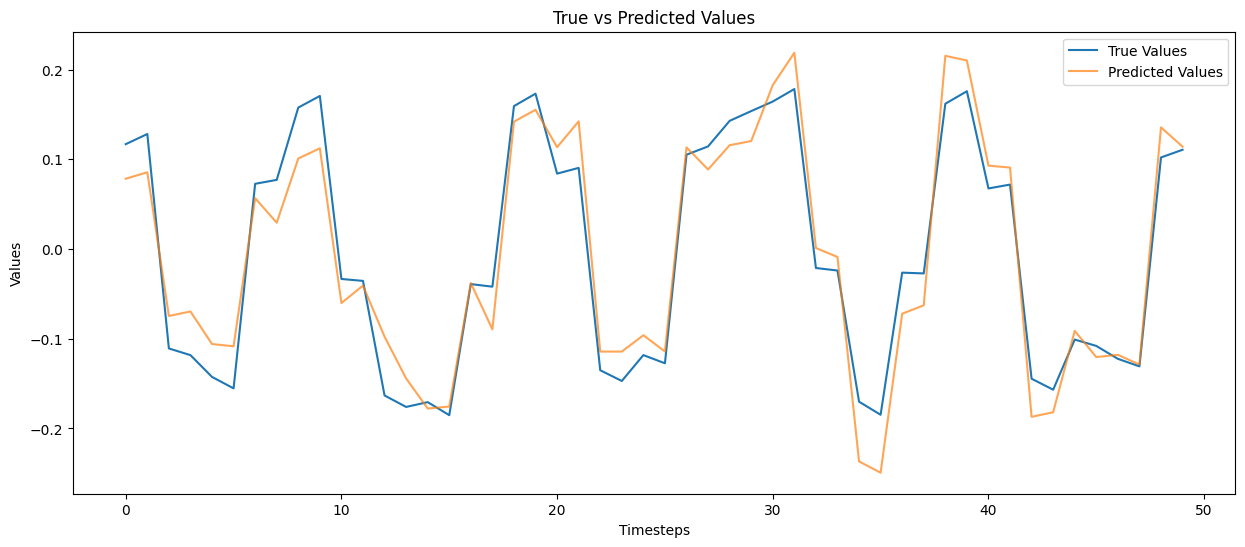

In [16]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(y_test[0][50:100], label='True Values')
plt.plot(predictions[0][50:100], label='Predicted Values', alpha=0.7)
plt.title('True vs Predicted Values')
plt.xlabel('Timesteps')
plt.ylabel('Values')
plt.legend()
plt.show()
